In [4]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPool2D, Reshape, Flatten

from keras.models import Model
from keras.callbacks import TensorBoard
from keras import metrics

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_context('poster')

import tensorflow as tf

import keras

import keras.layers

# PCA and linear autoencoders for MNIST

In [5]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
num_classes =10
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
# this is the size of our encoded representations
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='linear')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

2022-04-21 10:26:44.656735: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-21 10:26:44.656792: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (desk033): /proc/driver/nvidia/version does not exist
2022-04-21 10:26:44.659049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Variational Autoencoder

In [13]:
batch_size = 256
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
beta = .1
vae_loss = K.mean(xent_loss + beta*kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

In [14]:
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [15]:
%%time
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None),
        callbacks=[TensorBoard(log_dir='/tmp/autoencoder/vae')])

2022-04-21 10:26:45.054114: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
235/235 [==============================] - 6s 21ms/step - loss: 198.8713 - val_loss: 174.4003
Epoch 2/20
235/235 [==============================] - 5s 19ms/step - loss: 170.1436 - val_loss: 166.5359
Epoch 3/20
235/235 [==============================] - 4s 19ms/step - loss: 164.6285 - val_loss: 163.3488
Epoch 4/20
235/235 [==============================] - 5s 20ms/step - loss: 162.1282 - val_loss: 161.4053
Epoch 5/20
235/235 [==============================] - 4s 17ms/step - loss: 160.4842 - val_loss: 159.9933
Epoch 6/20
235/235 [==============================] - 4s 19ms/step - loss: 158.9571 - val_loss: 158.7742
Epoch 7/20
235/235 [==============================] - 4s 19ms/step - loss: 157.6547 - val_loss: 157.3609
Epoch 8/20
235/235 [==============================] - 5s 20ms/step - loss: 156.5275 - val_loss: 156.3545
Epoch 9/20
235/235 [==============================] - 4s 19ms/step - loss: 155.4778 - val_loss: 156.1414
Epoch 10/20
235/235 [==============================] - 

In [16]:
vae.layers

In [17]:
%%time
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = generator.predict(encoded_imgs)

CPU times: user 1.39 s, sys: 146 ms, total: 1.54 s
Wall time: 1.48 s


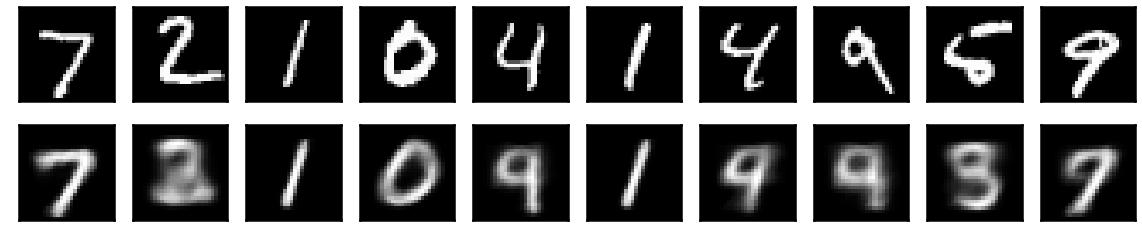

In [18]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [19]:
y2col = {
    0: 'black',
    1: 'red',
    2: 'pink',
    3: 'orange',
    4: 'yellow',
    5: 'mediumseagreen',
    6: 'green',
    7: 'cyan',
    8: 'blue',
    9: 'purple',
}

In [20]:
# x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# fig, ax = plt.subplots(figsize=(6,6))
# ax.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=[y2col[y] for y in y_test])
# ax.legend(handles=[mpatches.Patch(color=c, label=y) for y,c in y2col.items()], bbox_to_anchor=(1,1))

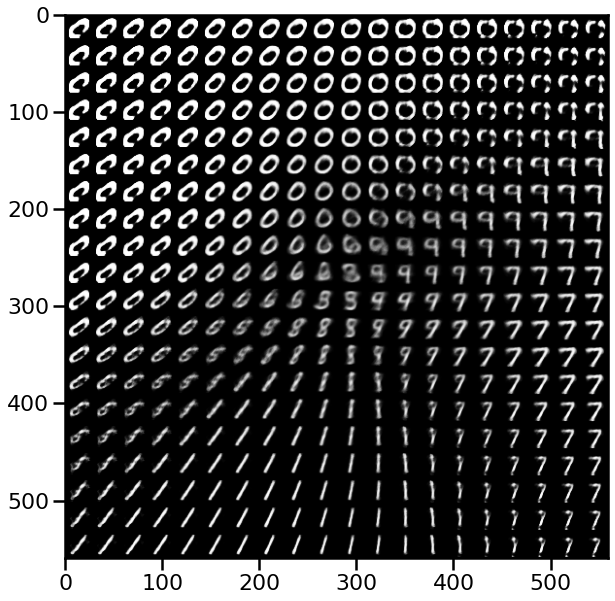

In [21]:
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
# grid_x = stats.norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = stats.norm.ppf(np.linspace(0.05, 0.95, n))
grid_x = np.linspace(-10,10,n)
grid_y = np.linspace(-10,10,n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-1-i) * digit_size: (n-i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, origin='upper')


# Add Classifier

In [22]:
import keras.applications

In [23]:
original_dim

784

In [24]:
x_input = Input(shape=(original_dim,))
x = vae(x_input, training=False)

x = Reshape((28,28,1), input_shape=(784,))(x)

x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1))(x)
x = MaxPool2D((2, 2))(x)
x = Flatten()(x)
x = Dense(100, activation='relu', kernel_initializer='he_uniform')(x)
x = Dense(10, activation='softmax')(x)

In [25]:
model = keras.Model(inputs=x_input, outputs=x, name="vae_classifier")

In [26]:
vae.trainable = False

In [27]:
model.summary()

Model: "vae_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 model_3 (Functional)        (None, 784)               404244    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                    

In [28]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [30]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
%%time
model.fit(x=x_train, y=y_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        callbacks=[TensorBoard(log_dir='/tmp/autoencoder/vae')])

Epoch 1/20
  1/235 [..............................] - ETA: 29s - loss: 151.1978 - accuracy: 0.7383

2022-04-21 12:42:57.666721: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


235/235 [==============================] - 15s 64ms/step - loss: 149.9336 - accuracy: 0.7202 - val_loss: 151.3013 - val_accuracy: 0.7074
Epoch 2/20
235/235 [==============================] - 15s 63ms/step - loss: 149.9395 - accuracy: 0.7199 - val_loss: 151.2905 - val_accuracy: 0.7090
Epoch 3/20
235/235 [==============================] - 15s 64ms/step - loss: 149.9357 - accuracy: 0.7213 - val_loss: 151.3224 - val_accuracy: 0.7051
Epoch 4/20
235/235 [==============================] - 15s 64ms/step - loss: 149.9359 - accuracy: 0.7204 - val_loss: 151.3253 - val_accuracy: 0.7045
Epoch 5/20
235/235 [==============================] - 15s 63ms/step - loss: 149.9342 - accuracy: 0.7199 - val_loss: 151.3225 - val_accuracy: 0.7036
Epoch 6/20
235/235 [==============================] - 15s 62ms/step - loss: 149.9373 - accuracy: 0.7202 - val_loss: 151.3232 - val_accuracy: 0.7058
Epoch 7/20
235/235 [==============================] - 15s 63ms/step - loss: 149.9315 - accuracy: 0.7204 - val_loss: 151.319